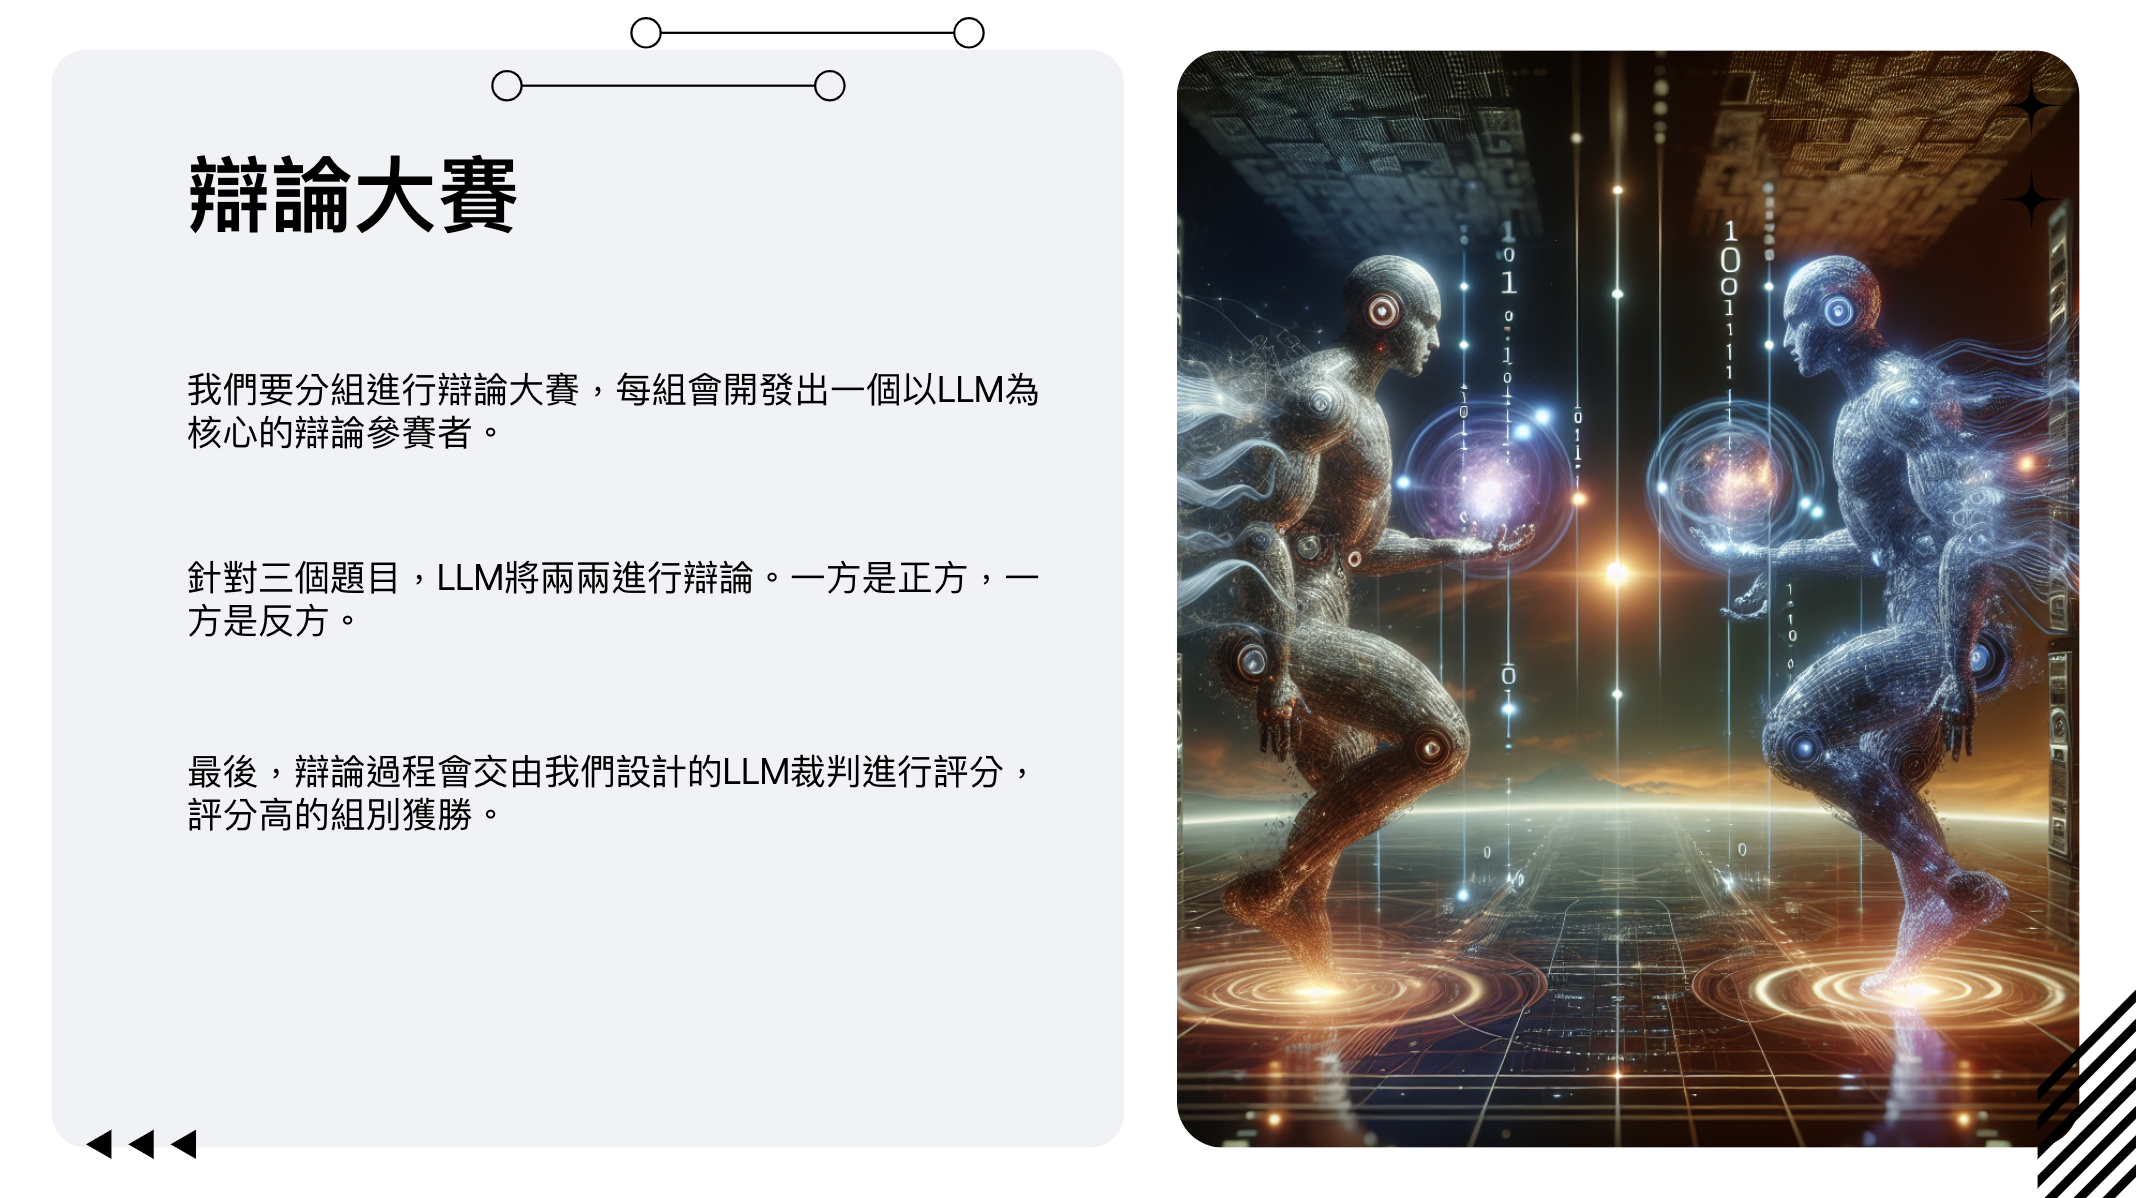

## 環境設置

In [25]:
# !git clone https://github.com/Ethan-Chiu/Gen-AI-Tut.git

In [26]:
import sys
sys.path.append('/content/Gen-AI-Tut')

In [27]:
!pip install langchain-anthropic
!pip install langchain-google-genai
!pip install sentence-transformers
!pip install langchain
!pip install chromadb

## 設定 API keys

In [28]:
import os
os.environ["GOOGLE_API_KEY"] = ""
os.environ["ANTHROPIC_API_KEY"] = ""
match_api_key = ""

# **流程圖**

<img src="https://drive.google.com/uc?id=1rBT-9JIfd5e5ReWWQLw_zojAgsy-Ml4S" width="70%"/>

## 設置LLM

我們會用到Gemini和Claude

In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

gemini = ChatGoogleGenerativeAI(temperature=0, model="gemini-pro", convert_system_message_to_human=True)
claude = ChatAnthropic(temperature=0,  model_name="claude-3-haiku-20240307")

## 建立Memory

### Memory 用來儲存對話紀錄。如果沒有把對話紀錄加到LLM的輸入中, LLM不會記得前面講過什麼。

這裡使用的memory種類是Conversation Buffer Memory.

▶ `max_token_limit` 指的是這個Memory最多能存多少Tokens, 避免LLM的輸入過長。

▶ 當對話紀錄超過這個長度的時候, 它會自動使用提供的LLM把對話紀錄做總結。這裡用的LLM是Gemini。

In [30]:
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import MessagesPlaceholder

memory = ConversationBufferMemory(llm=gemini, max_token_limit=1024, ai_prefix="")
# Show what are in the memory
memory.load_memory_variables({})

{'history': ''}

# RAG Chains

<img src="https://drive.google.com/uc?id=1tUa0i7DR_JiqCIFfQy8KucZDYFo8F3_Q" width="70%"/>



## 準備資料

<img src="https://drive.google.com/uc?id=1ZOxv08F6I68DGa2KZyyc1rmKSpsAu3yt" width="70%"/>


In [31]:
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_community.document_loaders import TextLoader


### Document loader 和 Text splitter

In [32]:
# Document loader
# Example for TextLoader
# loader = TextLoader("/content/Gen-AI-Tut/docs/rag/example.txt")
# txt_docs = loader.load()
loader = WebBaseLoader("http://class.heart.net.tw/article-132.shtml")

docs = loader.load()
print(f'文件數量: {len(docs)}')

# Text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=0)
splits = text_splitter.split_documents(docs)
print(f'切分後的段落數量: {len(splits)}')
chunk_size_list = [len(split.page_content) for split in splits]
print(f"每段內容長度: {chunk_size_list}")
print(f"段落內容範例: {splits[0].page_content}")

文件數量: 1
切分後的段落數量: 3
每段內容長度: [961, 997, 651]
段落內容範例: 班級經營資訊網/班級經營策略/如何運用早自修






如何運用早自修(下載DOC檔)


 
  原設計者：彰化師大數學系吳怡儒、電機系蔡國華、機電系潘霈榕
　






一、前言


			古人有言道，一日之計在於晨，要如何好好利用早上的時間是門大學問，記得我們還是國小、國中的時候，所謂的早自修時間往往是被拿來當作考試之用，而失去了活用的空間，這實在是一件相當可惜的事情，在接下來的部份，我們會探討早自修對於學生有什麼樣的幫助；我們老師有哪些地方要注意、要如何去規劃早自修，最後再提出幾個例子來做說明。

 

二、利用早自修時間的幾種方法

現在各個學校利用早自修的時間，大致上可分為下列幾種--

(1)  
			
			用於學科考試：這在很多學校中都是如此，因為早自修的時間長度剛好充當  


                 
小考，且有利於學生集中精神在接下來一天的課業。

(2)  
			
			用於加課：當課程進度有趕不上的時候，早自修往往會被拿來上課，但比較

             
不好的是，這時學生們的注意力都不太能集中，甚至是處於半睡


             
眠狀態，所以效果也不是很好。

(3)  
			
			作業檢查或導師時間：導師會利用這個時間管理班上事務，或者是檢查學生               
			

                      
			的作業是否完成，如果未完成則給予一天的時間重作。


			以上都是比較偏課內東西的，但其實早自修的內容也可以是課外的。可以用來增進學生其他的能力，甚至是人與人的相處，而不只是在課業上，例如--

(1)  
			
			舉辦慶生會：導師可再每個月固定一天的早自修舉辦慶生會，如此不僅可增 


               
進班上的感情及溫馨，又不會影響到正常上課的時間。

(2)  
			
			舉辦讀書會：可利用一週固定一個早自修時間，讓學生分享讀某本書後的心  


               
得，因為現在學生都很忙碌，大概也無法在下課後特地留下來，


               
這時早自修就是一個很好的時間了。

 

三、早自修的


### 算出Embedding, 將資料存入Vector store
collection_name代表存在哪個vector store裡，如果沒給的話全部資料都會存進同個vector store。

In [33]:
# Embeddings
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Vector store
vector = Chroma.from_documents(splits, embedding_function, collection_name="education")


In [34]:
# 需要清空vector store時執行下方的程式碼
# vector.delete_collection()

## 設定各個RAG chain的Prompt

In [35]:
environmental_template = """You are a passionate environmentalist with a deep understanding of ecological systems and sustainability principles. \
You excel at providing insightful explanations and solutions related to environmental issues in a clear and engaging manner. \
When faced with a question outside your expertise, you gracefully acknowledge your limitations.\

Answer the following question based on the provided context:

<context>
{context}
</context>

Here is the question:
{input}"""

education_template = """You are an enthusiastic and knowledgeable educator with a profound understanding of pedagogy and learning principles. \
You are adept at delivering comprehensive explanations and fostering engaging learning experiences.

Answer the following question with the provided context.

<context>
{context}
</context>

Here is the question:
{input}"""

## 填寫給Router看的information

In [36]:
prompt_infos = [
{
    "name": "environmentalist",
    "description": "Ideal for addressing environmental concerns and offering insightful solutions",
    "prompt_template": environmental_template,
},
{
    "name": "education",
    "description": "Good for answering questions related to education or study or 早自習",
    "prompt_template": education_template,
}]

## Build RAG chains

1.   **建立Retriever**: 取得Vector store和input有關的資訊
```
retriever = vector.as_retriever(search_kwargs={"k": 1})
```
k = 1 代表有一筆最相關的資料會被取出。


2.   **建立各個RAG chain**: 用對應的Retriever和Prompt去建立chains。



<img src="https://drive.google.com/uc?id=1JDmGDtT5lEN0TlqRSl1wZdExQXQKf9AI" width="70%"/>

In [37]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [38]:
retriever = vector.as_retriever(search_kwargs={"k": 1})
prompt = ChatPromptTemplate.from_template(template=environmental_template)

document_chain = create_stuff_documents_chain(claude, prompt)

enviromental_chain = create_retrieval_chain(retriever, document_chain)

In [39]:
retriever = vector.as_retriever(search_kwargs={"k": 1})
prompt = ChatPromptTemplate.from_template(template=education_template)

document_chain = create_stuff_documents_chain(claude, prompt)

education_chain = create_retrieval_chain(retriever, document_chain)

In [40]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

general_chain = RunnablePassthrough.assign(
    answer=(ChatPromptTemplate.from_template("{history} {input}") | claude | StrOutputParser())
)

# **Router Chain**

### 設定 MULTI_PROMPT_ROUTER_TEMPLATE

這個 Prompt 輸入的Data會類似這樣:

<img src="https://drive.google.com/uc?id=1XvhG3oqmM3aezFBnfVD2_nNVbj1vMX00" width="50%"/>

目的是請 Router LLM 輸出一個 json

這個 Prompt 內容包含：

<< HISTORY >> (對話紀錄)

<< INPUT >> (輸入的問題)

<< FORMATTING >> (告訴LLM 輸出格式與內容)
*   統整目前辯論歷史訊息, 輸出至`next_input`
*   決定將問題交給哪個RAG chain回答, 輸出至`destination`

<< CANDIDATE PROMPTS >> (有哪些RAG可以用)

<< OUTPUT (remember to include the ```json)>>


In [41]:
MULTI_PROMPT_ROUTER_TEMPLATE = """
你是一個router，你的工作是分析input的問題與甚麼領域有關，\
當問題不清楚時適當修改問題，接著把問題傳遞給適當的language model.\
你會得到所有可以選擇的language model名稱及它們擅長哪個領域的問題。\

You can also use the history messages provided here to make your decision.
<< HISTORY >>
{{history}}

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:

\```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ summary of the history relevant to the topic of input
}}}}
\```

REMEMBER: "destination" MUST be one of the candidate prompt \
names specified below OR it can be "DEFAULT" if the input is completely\
unrelated to any of the candidate prompts.
REMEMBER: "next_inputs" should contain a concise summary of the history to provide context for the input.


<< CANDIDATE DESTINATIONS >>
{destinations}

<< INPUT >>
{{input}}

<< OUTPUT (remember to include the ```json)>>"""

### 將 destinations_str 填入 Prompt 中

讓 Router chain 知道有哪些不同領域的專家可以回答問題

destinations_str 範例如下圖


```
environmentalist: Ideal for addressing environmental concerns and offering insightful solutions
education: Good for answering questions related to education or study or 早自習
```

In [42]:
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

router_system_template = PromptTemplate.from_template(MULTI_PROMPT_ROUTER_TEMPLATE).format(destinations=destinations_str)
router_prompt = ChatPromptTemplate.from_template(router_system_template)


## Route to Destination

<img src="https://drive.google.com/uc?id=1O4UjB0oIgwMBOxVHf9W1MXSZHBOV_Wtq" width="70%"/>

In [43]:
def route(data):
    print(f"Router 決定給:{data['destination']}，輸出給RAG的input是:{data['input'][:50]} ......，對話紀錄: {data['history'][:50]}......")
    if data["destination"]:
        if "environmentalist" in data["destination"].lower():
            return enviromental_chain
        elif "education" in data["destination"].lower():
            return education_chain
    else:
        return general_chain

# Build Chain

## Build Router Chain

<img src="https://drive.google.com/uc?id=1VKlZygxIZz03r8u6kTUPLqmyyyECjoDy" width="70%"/>

In [44]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.chains.router.llm_router import RouterOutputParser
from operator import itemgetter

router_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
    )
    | router_prompt
    | claude
    | RouterOutputParser()
    | {"destination": itemgetter("destination"), "next_inputs": lambda x: x["next_inputs"]['input']}
)

##  Build Multi-prompt chain

<img src="https://drive.google.com/uc?id=1Sxa5eWgXCzhAqNN2I_Vf00OYxDvGCS_n" width="70%"/>

<img src="https://drive.google.com/uc?id=1O4UjB0oIgwMBOxVHf9W1MXSZHBOV_Wtq" width="70%"/>

<img src="https://drive.google.com/uc?id=1D2h_v6amHHJybL3yB0muRddJGkC758SC" width="70%"/>

In [45]:

multi_prompt_chain = (
    RunnablePassthrough.assign(
        route=router_chain
    )
    | {
        "destination": lambda x: x["route"]["destination"],
        "input": lambda x: f'{x["route"]["next_inputs"]}\n{x["input"]}'
    }
    | RunnablePassthrough.assign(
        history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
    )
    | RunnableLambda(route)
)

# 線上比賽

In [46]:
from api.server import Server

server = Server("https://gen-ai-tut-backend.up.railway.app", match_api_key)
# server = Server("http://localhost:3000", "d8f8bc5e-4176-468c-8d78-5fdd73a50fe5")

In [47]:
from api.game import Game, validate_chain, show_result

valid = validate_chain(multi_prompt_chain,memory)

if valid:
  print("You're ready")
  game = Game(server, multi_prompt_chain, memory)
else:
  print("Something went wrong")

Router 決定給:None，輸出給RAG的input是:The input 'test' is a very short and generic query ......，對話紀錄: ......
You're ready


In [48]:
game.select_match()

All matches:
Match ID: 33, Name: Group 10 vs Group 16 -topic 3, Topic ID: 3, Match Status: START, Players: [], History Messages: []
Enter match: (ID: 33)


In [49]:
game.start()

Match ID: 33, Name: 3, Topic ID: Group 10 vs Group 16 -topic 3, Players: [<api.models.player.Player object at 0x7f2d511f0fa0>, <api.models.player.Player object at 0x7f2d4cc6a050>], Topic: Topic ID: 3, Description: AI創作註明, Is First: False, Result: None
Topic: AI創作註明
Match: 3
Opponent's turn first
正方立場:支持使用AI工具協助的創作成品需註明有使用AI協助

1. 消費者知情權:消費者有權知道所購買的創作作品是否使用了AI工具協助。這關乎消費者的知情權和選擇權,讓消費者能夠做出明智的購買決定。

2. 創作者誠信:不註明使用AI工具,等同於隱瞞事實,損害了創作者的誠信。消費者有權知道作品的創作過程和貢獻來源。

3. 促進技術發展:透明地註明使用AI工具,有助於推動AI技術在創意領域的應用和進步。這有利於AI工具的持續改進和創新。

4. 保護原創性:註明使用AI工具可以避免作品被誤認為完全由人類創作,有助於維護真正人類創作者的權益和原創性。

5. 規範市場秩序:制定相關規範,要求註明使用AI工具,有助於規範市場秩序,防止誤導消費者。這也有利於公平競爭。

總之,支持使用AI工具協助的創作成品需註明,是為了保護消費者權益、維護創作者誠信、促進技術進步,並規範市場秩序。這有利於AI創作生態的健康發展。
Router 決定給:None，輸出給RAG的input是:The user has presented a debate topic on whether c ......，對話紀錄: Human: 使用AI工具協助繪圖或寫文章等創作成品是否需要註明有使用AI協助？對此，請正反雙方展開......
反方立場:反對使用AI工具協助的創作成品需註明有使用AI協助

1. 創作者自主權:創作者應有自主決定是否使用AI工具的權利,不應被強制要求註明。這涉及創作者的個人選擇和創作自由。

2. 影響創作價值:強制註明使用AI工具,可能會降低作品在消費者心目中的價值和地位,不利於創作者的

In [50]:
show_result(server)

Your match Group 10 vs Group 16 -topic 3 is graded
You lose!
You got 3 point


Grading info:
Good. very good
--------------------------------------------------------------------------------




# 本地測試

In [ ]:
inputs = {"input":
"""兩位參賽者進行辯論比賽，今天的討論議題是支不支持廢除早自習?
正方：支持廢除早自習
反方：反對廢除早自習

作為正方，請堅守支持廢除早自習的立場，並簡明扼要地陳述正方的意見和理由。
正方:"""}
response = multi_prompt_chain.invoke(inputs)
print(response.get("answer"))
memory.save_context(inputs, {"output": response.get("answer")})

In [ ]:
inputs = {"input":
"""作為反方，請堅守反對廢除早自習的立場，簡明扼要地陳述你的意見和理由。
反方:"""
}
response = multi_prompt_chain.invoke(inputs)
print(response.get("answer"))
memory.save_context(inputs, {"output": response.get("answer")})

In [ ]:
inputs = {"input":
"""作為正方，請堅守支持廢除早自習的立場。請針對反對方所發表的意見，進行反駁。
正方:"""}
response = multi_prompt_chain.invoke(inputs)
print(response.get("answer"))
memory.save_context(inputs, {"output": response.get("answer")})

In [ ]:
inputs = {"input":
"""作為反方，請堅守反對廢除早自習的立場。請針對正方所發表的意見，進行反駁。
反方:"""}
response = multi_prompt_chain.invoke(inputs)
print(response.get("answer"))
memory.save_context(inputs, {"output": response.get("answer")})